## Compare classification with different 1D DCT functions

In [1]:
import numpy as np
import utils.makeDataset as DatasetMaker
from utils.training import show_confusion_matrix, unique_images, get_average_dct, save_model_and_label_encoder
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
import os

In [2]:
OUTPUT_DATA_FOLDER = '../output/datasets/'
INPUT_DATA_FOLDER = '../data/'

DATASETS = ["d1_Q90", "d2_Q90", "d3_Q90"]  # Q90 with d1 d2 d3 and random roundings
# DATASETS = [19, 20, 21]  # Q90 with d1 d2 d3 and random roundings

MODEL_CATEGORY = "d_Q90"
BL_COMPUTE_AVG = False

In [3]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

MODELS = {
    "rf": RandomForestClassifier(max_depth=10, random_state=0),
    "adaboost": AdaBoostClassifier(),
    "svm": make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True)),
    "naive_bayes": GaussianNB()
}

### Loading data and preprocessing

In [4]:
from sklearn import preprocessing

X = []
y_labels = []

for current_dataset in DATASETS:
    _, X_current = DatasetMaker.load_dataset(current_dataset)
    y_labels += [current_dataset] * len(X_current)
    if BL_COMPUTE_AVG:
        X += get_average_dct(X_current)
    else:
        X += X_current

le = preprocessing.LabelEncoder()
y = le.fit_transform(y_labels)

new_X, new_y = unique_images(X, y.tolist())

### Cross val predict for each model to test

              precision    recall  f1-score   support

      d1_Q90       0.92      0.97      0.94       200
      d2_Q90       0.89      0.91      0.90       200
      d3_Q90       0.96      0.88      0.92       200

    accuracy                           0.92       600
   macro avg       0.92      0.92      0.92       600
weighted avg       0.92      0.92      0.92       600



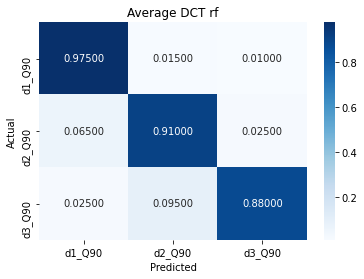

              precision    recall  f1-score   support

      d1_Q90       0.89      0.98      0.93       200
      d2_Q90       0.67      0.76      0.71       200
      d3_Q90       0.78      0.60      0.68       200

    accuracy                           0.78       600
   macro avg       0.78      0.78      0.77       600
weighted avg       0.78      0.78      0.77       600



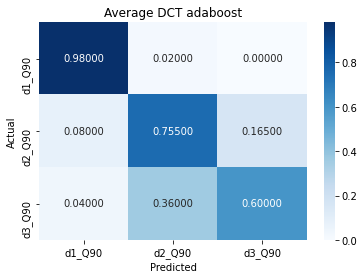

              precision    recall  f1-score   support

      d1_Q90       0.89      0.96      0.93       200
      d2_Q90       0.66      0.66      0.66       200
      d3_Q90       0.71      0.66      0.68       200

    accuracy                           0.76       600
   macro avg       0.75      0.76      0.75       600
weighted avg       0.75      0.76      0.75       600



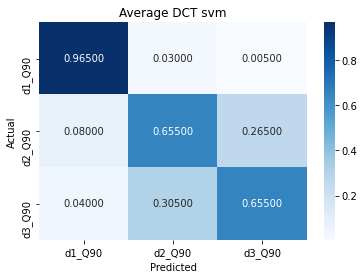

              precision    recall  f1-score   support

      d1_Q90       0.91      0.91      0.91       200
      d2_Q90       0.81      0.78      0.79       200
      d3_Q90       0.86      0.89      0.87       200

    accuracy                           0.86       600
   macro avg       0.86      0.86      0.86       600
weighted avg       0.86      0.86      0.86       600



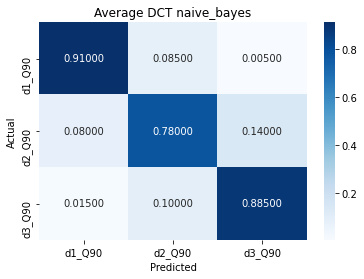

In [5]:
from sklearn.model_selection import cross_val_predict

for model in MODELS.keys():
    y_pred = cross_val_predict(MODELS[model], new_X, new_y, cv=5)
    print(classification_report(new_y, y_pred, target_names=DATASETS))
    show_confusion_matrix(new_y, y_pred, DATASETS, f"Average DCT {model}")

### Compare best model for each Qf

              precision    recall  f1-score   support

      d1_Q10       0.94      0.98      0.96       200
      d2_Q10       0.97      0.95      0.96       200
      d3_Q10       0.99      0.97      0.98       200

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



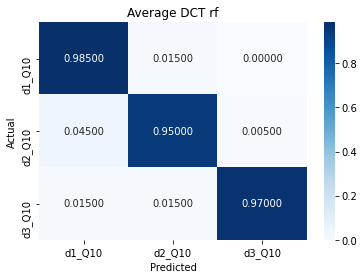

              precision    recall  f1-score   support

      d1_Q50       0.92      0.97      0.94       200
      d2_Q50       0.93      0.89      0.91       200
      d3_Q50       0.95      0.93      0.94       200

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600



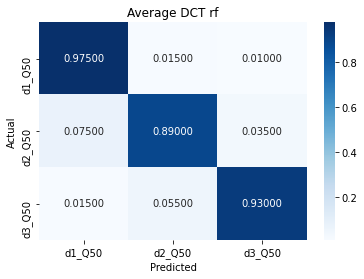

              precision    recall  f1-score   support

      d1_Q90       0.92      0.97      0.94       200
      d2_Q90       0.89      0.91      0.90       200
      d3_Q90       0.96      0.88      0.92       200

    accuracy                           0.92       600
   macro avg       0.92      0.92      0.92       600
weighted avg       0.92      0.92      0.92       600



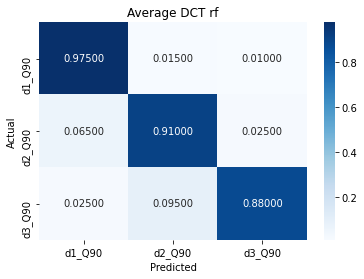

In [6]:
datasets_compare = [["d1_Q10", "d2_Q10", "d3_Q10"], ["d1_Q50", "d2_Q50", "d3_Q50"], ["d1_Q90", "d2_Q90", "d3_Q90"]]
for curr_datasets in datasets_compare:
    X = []
    y_labels = []

    for current_dataset in curr_datasets:
        _, X_current = DatasetMaker.load_dataset(current_dataset)
        y_labels += [current_dataset] * len(X_current)
        if BL_COMPUTE_AVG:
            X += get_average_dct(X_current)
        else:
            X += X_current

    le = preprocessing.LabelEncoder()
    y = le.fit_transform(y_labels)

    new_X, new_y = unique_images(X, y.tolist())
    y_pred = cross_val_predict(MODELS["rf"], new_X, new_y, cv=5)
    print(classification_report(new_y, y_pred, target_names=curr_datasets))
    show_confusion_matrix(new_y, y_pred, curr_datasets, f"Average DCT rf")

## Train and save best model

In [9]:
# DATASETS = ["d1_Q90", "d2_Q90", "d3_Q90"]  # Q90 with d1 d2 d3 and random roundings
# MODEL_CATEGORY = "d_Q90"
#
#
# MODEL_TYPE = "rf"
# PATH_MODELS = f"../models/final_models/{MODEL_CATEGORY}/"
# MODEL_NAME = ''.join([str(MODEL_TYPE)] + ['_' + str(curr) for curr in DATASETS])
# model = MODELS[MODEL_TYPE]
#
# X = []
# y_labels = []
#
# for current_dataset in DATASETS:
#     _, X_current = DatasetMaker.load_dataset(current_dataset)
#     y_labels += [current_dataset] * len(X_current)
#     if BL_COMPUTE_AVG:
#         X += get_average_dct(X_current)
#     else:
#         X += X_current
#
# le = preprocessing.LabelEncoder()
# y = le.fit_transform(y_labels)


In [10]:
# model.fit(X, y)
# save_model_and_label_encoder(model, le, PATH_MODELS, MODEL_NAME)

### Bonus : try to train a single classifier to predict d for any value of Qf

              precision    recall  f1-score   support

          d1       0.74      0.59      0.66       166
          d2       0.60      0.77      0.67       166
          d3       0.86      0.80      0.83       166

    accuracy                           0.72       498
   macro avg       0.74      0.72      0.72       498
weighted avg       0.74      0.72      0.72       498



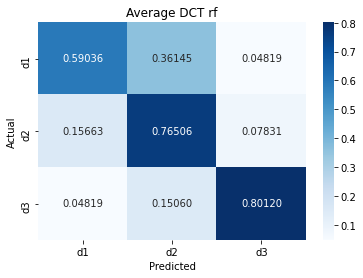

In [11]:
DATASETS = ["d1", "d2", "d3"]  # d1 d2 d3 and random Qf and roundings
X = []
y_labels = []

for current_dataset in DATASETS:
    _, X_current = DatasetMaker.load_dataset(current_dataset)
    y_labels += [current_dataset] * len(X_current)
    X += X_current

le = preprocessing.LabelEncoder()
y = le.fit_transform(y_labels)

new_X, new_y = unique_images(X, y.tolist())
y_pred = cross_val_predict(MODELS["rf"], new_X, new_y, cv=5)
print(classification_report(new_y, y_pred, target_names=DATASETS))
show_confusion_matrix(new_y, y_pred, DATASETS, f"Average DCT rf")

